In [1]:
"""
# Análisis Exploratorio Visual - Dataset de Segmentación de Núcleos
## Proyecto de Segmentación de Núcleos Celulares

Este notebook realiza un análisis exploratorio visual detallado del dataset de segmentación 
de núcleos celulares, enfocándose en:

1. Visualización de imágenes y máscaras
2. Análisis de propiedades estadísticas
3. Identificación de casos desafiantes
4. Evaluación de variabilidad en el dataset

Autor: Tomy
Fecha: Agosto 2025
"""

'\n# Análisis Exploratorio Visual - Dataset de Segmentación de Núcleos\n## Proyecto de Segmentación de Núcleos Celulares\n\nEste notebook realiza un análisis exploratorio visual detallado del dataset de segmentación \nde núcleos celulares, enfocándose en:\n\n1. Visualización de imágenes y máscaras\n2. Análisis de propiedades estadísticas\n3. Identificación de casos desafiantes\n4. Evaluación de variabilidad en el dataset\n\nAutor: Tomy\nFecha: Agosto 2025\n'

## 1. Configuración y Carga de Dependencias

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from collections import Counter, defaultdict
import random
from tqdm import tqdm
import seaborn as sns
from skimage import measure
from scipy import ndimage

# Configuración de visualización
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn-v0_8-whitegrid')

# Directorio de datos
DATA_DIR = Path('../data')

## 2. Funciones Auxiliares para Carga y Visualización

In [4]:
def load_sample(sample_dir):
    """
    Carga una muestra (imagen + máscara) de un directorio específico.
    
    Args:
        sample_dir (Path): Directorio que contiene image.png y mask.png
        
    Returns:
        dict: Diccionario con imagen y máscara cargadas, además de metadatos
    """
    image_path = sample_dir / "image.png"
    mask_path = sample_dir / "mask.png"
    
    if not (image_path.exists() and mask_path.exists()):
        return None
    
    # Cargar imagen y convertir a RGB
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Cargar máscara binaria
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    
    # Binarizar máscara (por si acaso valores no son exactamente 0 y 255)
    _, mask_binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    # Contar núcleos (componentes conectados)
    num_labels, labels = cv2.connectedComponents(mask_binary)
    num_nuclei = num_labels - 1  # Restamos 1 para excluir el fondo
    
    return {
        'sample_id': sample_dir.name,
        'image': image,
        'mask': mask_binary,
        'num_nuclei': num_nuclei,
        'image_height': image.shape[0],
        'image_width': image.shape[1],
        'mask_foreground_ratio': np.sum(mask_binary > 0) / mask_binary.size,
        'mask_unique_values': np.unique(mask_binary)
    }

def get_random_samples(num_samples=5, seed=42):
    """
    Selecciona muestras aleatorias del dataset.
    
    Args:
        num_samples (int): Número de muestras a seleccionar
        seed (int): Semilla para reproducibilidad
        
    Returns:
        list: Lista de directorios de muestras seleccionadas
    """
    random.seed(seed)
    sample_dirs = [d for d in DATA_DIR.iterdir() if d.is_dir() and d.name.isdigit()]
    return random.sample(sample_dirs, min(num_samples, len(sample_dirs)))

def find_edge_cases(num_samples=200, return_top=5):
    """
    Encuentra casos extremos en el dataset basados en diferentes criterios.
    
    Args:
        num_samples (int): Número de muestras a analizar
        return_top (int): Número de casos extremos a retornar por categoría
        
    Returns:
        dict: Diccionario con casos extremos por categoría
    """
    # Muestrear directorios aleatoriamente
    sample_dirs = get_random_samples(num_samples, seed=42)
    
    # Contenedores para métricas
    metrics = {
        'most_nuclei': [],     # Muestras con más núcleos
        'least_nuclei': [],    # Muestras con menos núcleos
        'highest_density': [], # Mayor proporción de área ocupada por núcleos
        'lowest_density': [],  # Menor proporción de área ocupada por núcleos
        'small_nuclei': [],    # Muestras con núcleos muy pequeños
        'touching_nuclei': [], # Muestras con núcleos que se tocan
        'varied_brightness': [] # Muestras con alta variación de brillo
    }
    
    print(f"Analizando {len(sample_dirs)} muestras para encontrar casos extremos...")
    
    for sample_dir in tqdm(sample_dirs):
        sample = load_sample(sample_dir)
        if sample is None:
            continue
            
        # Métricas básicas
        metrics['most_nuclei'].append((sample_dir, sample['num_nuclei']))
        metrics['least_nuclei'].append((sample_dir, sample['num_nuclei']))
        metrics['highest_density'].append((sample_dir, sample['mask_foreground_ratio']))
        metrics['lowest_density'].append((sample_dir, sample['mask_foreground_ratio']))
        
        # Análisis de componentes para encontrar núcleos pequeños
        labels, num = ndimage.label(sample['mask'])
        if num > 0:
            sizes = ndimage.sum(sample['mask'], labels, range(1, num + 1))
            smallest_size = np.min(sizes) if len(sizes) > 0 else float('inf')
            metrics['small_nuclei'].append((sample_dir, smallest_size))
            
            # Detectar núcleos que potencialmente se tocan
            mask_dilated = cv2.dilate(sample['mask'], np.ones((5,5), np.uint8), iterations=1)
            touching_score = np.sum(mask_dilated) / np.sum(sample['mask']) - 1
            metrics['touching_nuclei'].append((sample_dir, touching_score))
        
        # Variabilidad de brillo en la imagen
        gray = cv2.cvtColor(sample['image'], cv2.COLOR_RGB2GRAY)
        brightness_std = np.std(gray)
        metrics['varied_brightness'].append((sample_dir, brightness_std))
    
    # Encontrar los casos extremos
    edge_cases = {}
    edge_cases['most_nuclei'] = sorted(metrics['most_nuclei'], key=lambda x: x[1], reverse=True)[:return_top]
    edge_cases['least_nuclei'] = sorted(metrics['least_nuclei'], key=lambda x: x[1])[:return_top]
    edge_cases['highest_density'] = sorted(metrics['highest_density'], key=lambda x: x[1], reverse=True)[:return_top]
    edge_cases['lowest_density'] = sorted(metrics['lowest_density'], key=lambda x: x[1])[:return_top]
    edge_cases['small_nuclei'] = sorted(metrics['small_nuclei'], key=lambda x: x[1])[:return_top]
    edge_cases['touching_nuclei'] = sorted(metrics['touching_nuclei'], key=lambda x: x[1], reverse=True)[:return_top]
    edge_cases['varied_brightness'] = sorted(metrics['varied_brightness'], key=lambda x: x[1], reverse=True)[:return_top]
    
    return edge_cases

## 3. Visualización de Muestras Representativas

In [5]:
def visualize_samples(sample_dirs, title="Muestras del Dataset"):
    """
    Visualiza múltiples muestras del dataset con sus máscaras y contornos.
    
    Args:
        sample_dirs (list): Lista de directorios de muestras a visualizar
        title (str): Título para la figura
    """
    n_samples = len(sample_dirs)
    fig, axes = plt.subplots(n_samples, 3, figsize=(15, 5*n_samples))
    
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i, sample_dir in enumerate(sample_dirs):
        sample = load_sample(sample_dir)
        if sample is None:
            continue
        
        # Imagen original
        axes[i, 0].imshow(sample['image'])
        axes[i, 0].set_title(f"Imagen Original\n{sample_dir.name}")
        axes[i, 0].axis('off')
        
        # Máscara binaria
        axes[i, 1].imshow(sample['mask'], cmap='gray')
        axes[i, 1].set_title(f"Máscara Binaria\n{sample['num_nuclei']} núcleos")
        axes[i, 1].axis('off')
        
        # Superposición con contornos para ver bordes
        overlay = sample['image'].copy()
        
        # Encontrar contornos en la máscara
        contours, _ = cv2.findContours(
            sample['mask'], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
        
        # Dibujar contornos en la imagen original
        cv2.drawContours(overlay, contours, -1, (0, 255, 0), 2)
        
        axes[i, 2].imshow(overlay)
        axes[i, 2].set_title("Imagen con Contornos")
        axes[i, 2].axis('off')
    
    plt.suptitle(title, fontsize=16, y=0.92)
    plt.tight_layout()
    plt.show()

### 3.1 Visualización de Muestras Aleatorias

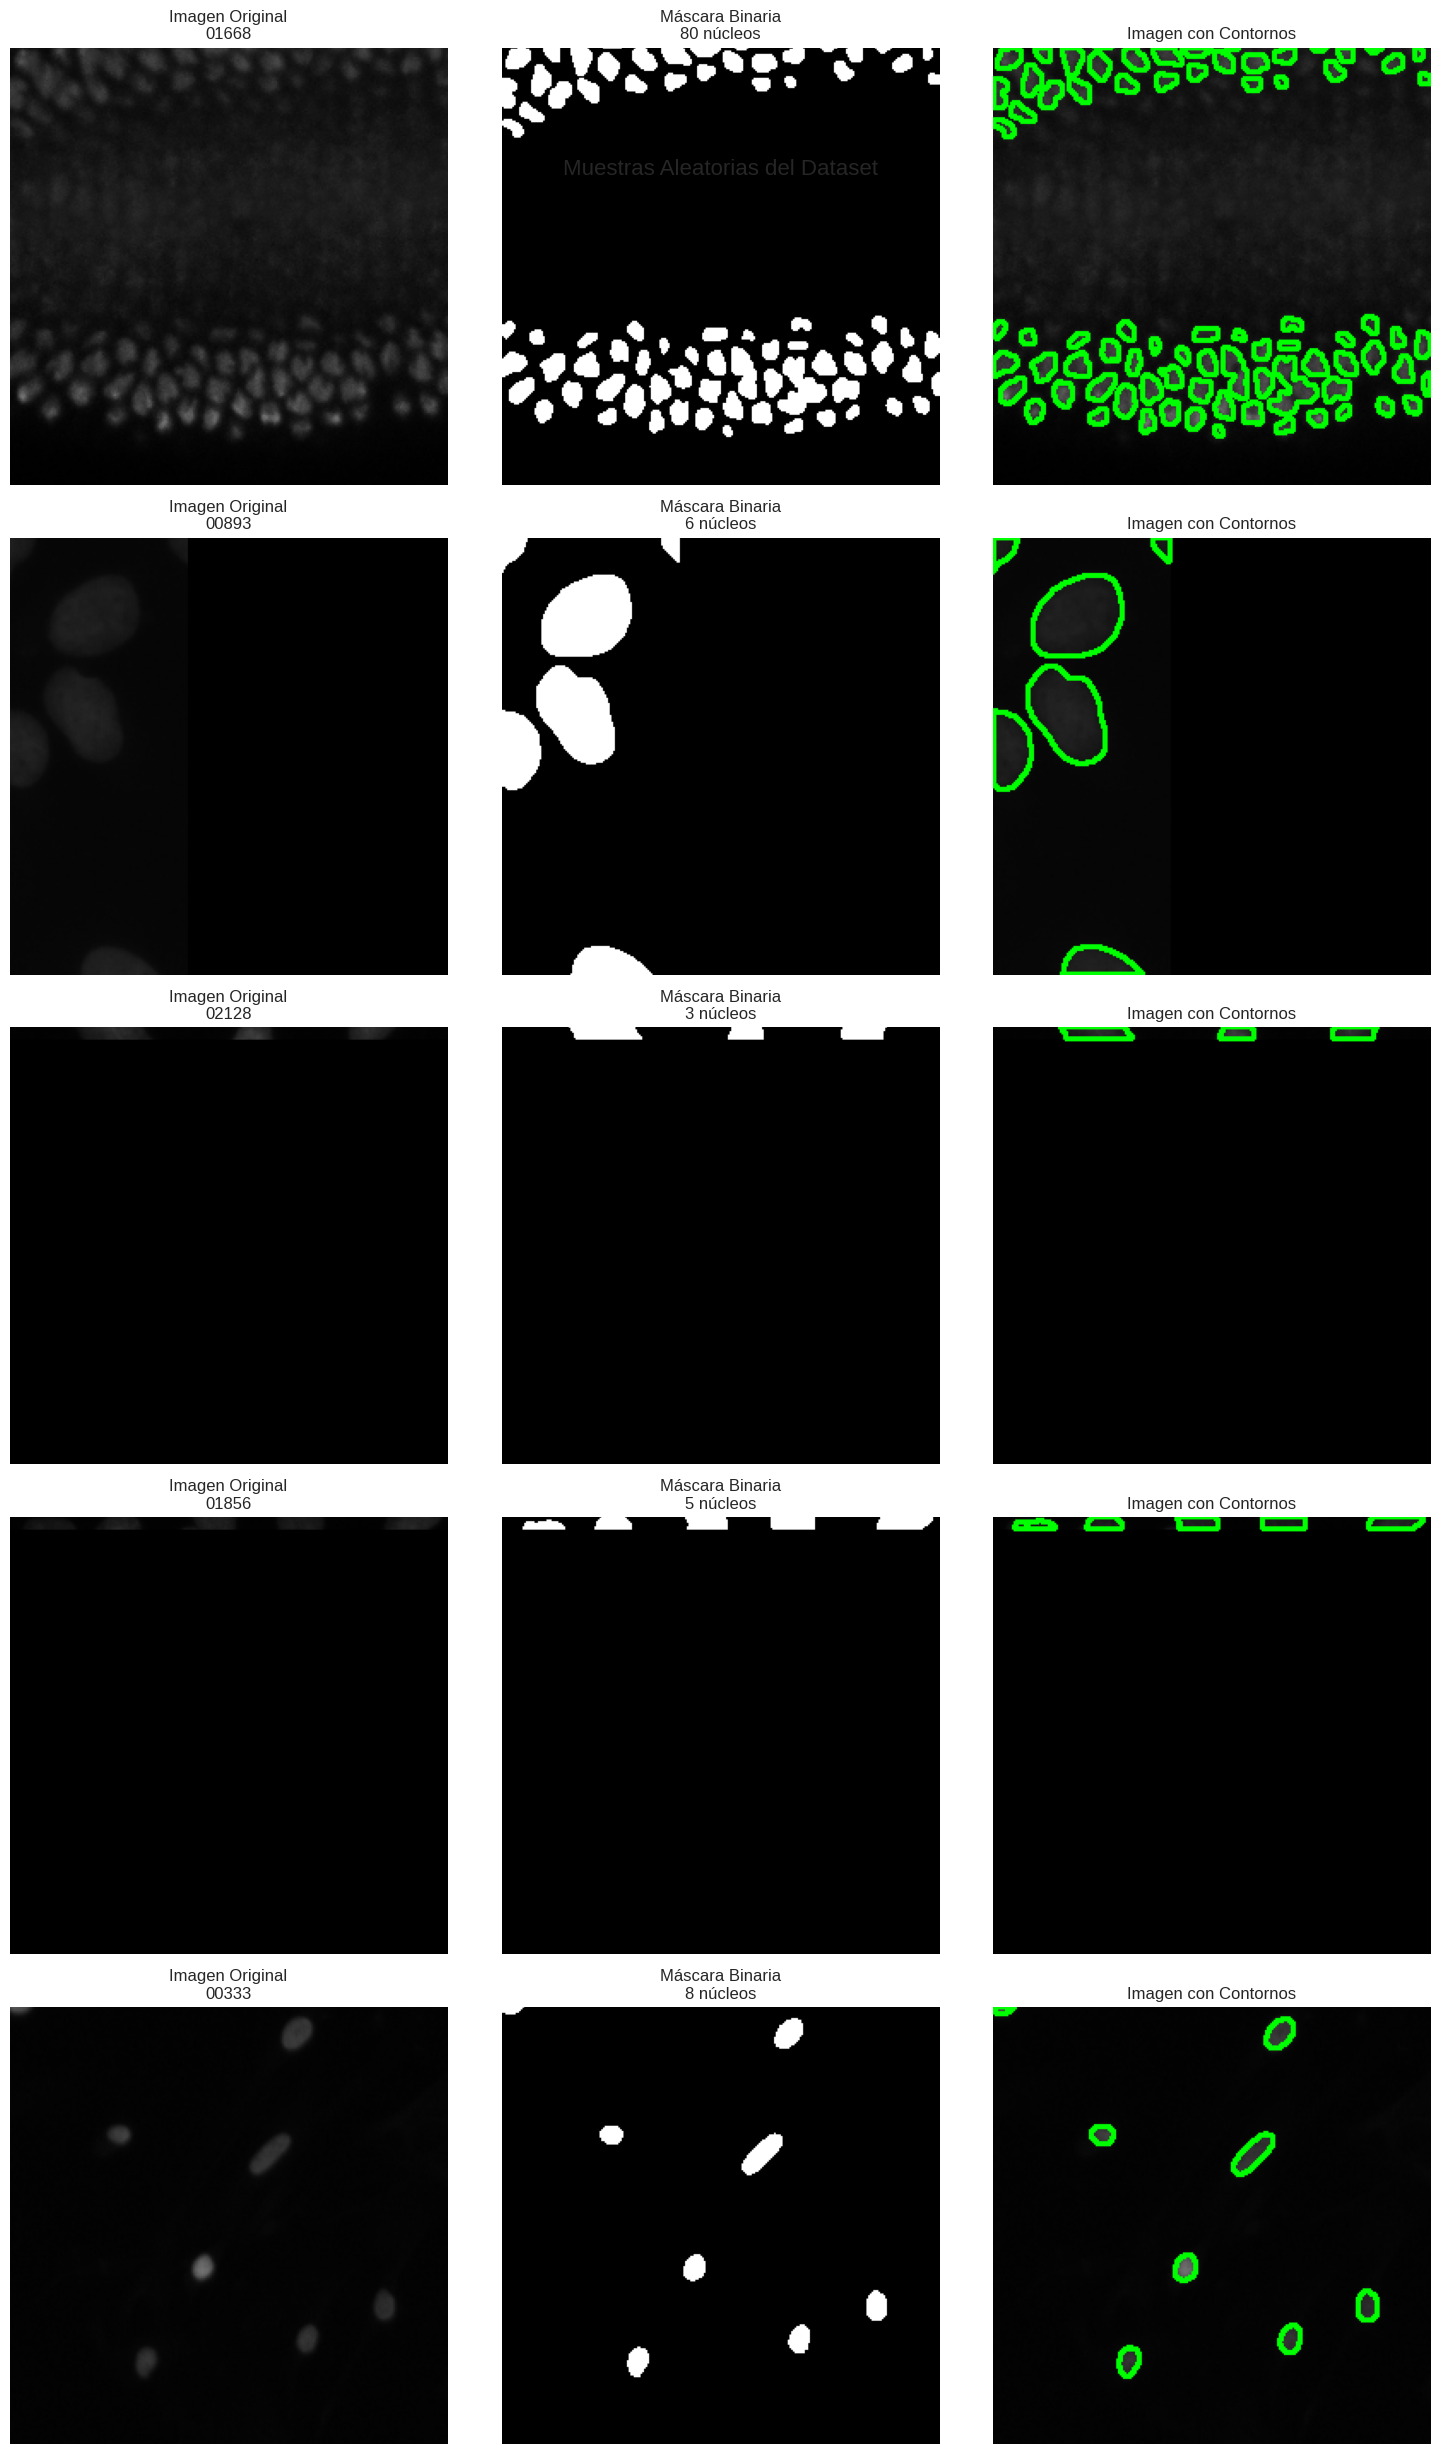

In [6]:
# Obtener y visualizar muestras aleatorias
random_samples = get_random_samples(5)
visualize_samples(random_samples, "Muestras Aleatorias del Dataset")

## 4. Análisis de Estadísticas del Dataset

In [8]:
def compute_dataset_statistics(num_samples=200):
    """
    Calcula estadísticas descriptivas del dataset.
    
    Args:
        num_samples (int): Número de muestras a analizar
        
    Returns:
        pd.DataFrame: DataFrame con estadísticas por muestra
    """
    # Muestrear directorios aleatoriamente
    sample_dirs = get_random_samples(num_samples, seed=123)
    
    stats_list = []
    for sample_dir in tqdm(sample_dirs):
        sample = load_sample(sample_dir)
        if sample is None:
            continue
            
        # Análisis de componentes para estadísticas de núcleos
        labels, num_components = ndimage.label(sample['mask'])
        
        if num_components > 0:
            sizes = ndimage.sum(sample['mask'] > 0, labels, range(1, num_components + 1))
            
            stats = {
                'sample_id': sample_dir.name,
                'num_nuclei': num_components,
                'foreground_ratio': sample['mask_foreground_ratio'],
                'avg_nucleus_size': np.mean(sizes),
                'min_nucleus_size': np.min(sizes),
                'max_nucleus_size': np.max(sizes),
                'std_nucleus_size': np.std(sizes),
            }
            
            # Análisis de brillo y contraste en imagen original
            gray = cv2.cvtColor(sample['image'], cv2.COLOR_RGB2GRAY)
            stats['image_mean_intensity'] = np.mean(gray)
            stats['image_std_intensity'] = np.std(gray)
            
            stats_list.append(stats)
    
    return pd.DataFrame(stats_list)

In [9]:
# Calcular estadísticas de una muestra del dataset
df_stats = compute_dataset_statistics(200)

# Mostrar resumen estadístico
print("Estadísticas Descriptivas del Dataset:")
print(df_stats.describe())

100%|██████████| 200/200 [00:00<00:00, 353.47it/s]

Estadísticas Descriptivas del Dataset:
       num_nuclei  foreground_ratio  avg_nucleus_size  min_nucleus_size  \
count  182.000000        182.000000        182.000000        182.000000   
mean    11.719780          0.088379        622.319652        206.983516   
std     12.169773          0.091314        734.268391        631.658883   
min      1.000000          0.000336         11.000000          1.000000   
25%      3.000000          0.013943        188.500000         22.000000   
50%      6.500000          0.055443        376.102941         52.000000   
75%     15.750000          0.133858        793.102273        147.750000   
max     52.000000          0.386459       7364.000000       7364.000000   

       max_nucleus_size  std_nucleus_size  image_mean_intensity  \
count        182.000000        182.000000            182.000000   
mean        1280.313187        339.102316             44.097526   
std         1245.894773        384.114397             71.437425   
min           14.

In [10]:
print(df_stats)

    sample_id  num_nuclei  foreground_ratio  avg_nucleus_size  \
0       00147           4          0.121384       1988.750000   
1       00642           2          0.002686         88.000000   
2       00460           8          0.089890        736.375000   
3       00587          11          0.051270        305.454545   
4       01087          37          0.332764        589.405405   
..        ...         ...               ...               ...   
177     00389          51          0.292374        375.705882   
178     00727          10          0.214935       1408.600000   
179     02116           4          0.015366        251.750000   
180     01663          32          0.054199        111.000000   
181     00386          43          0.220383        335.883721   

     min_nucleus_size  max_nucleus_size  std_nucleus_size  \
0              1435.0            2510.0        398.323596   
1                28.0             148.0         60.000000   
2                13.0            165

### 4.1 Visualización de Distribuciones Estadísticas

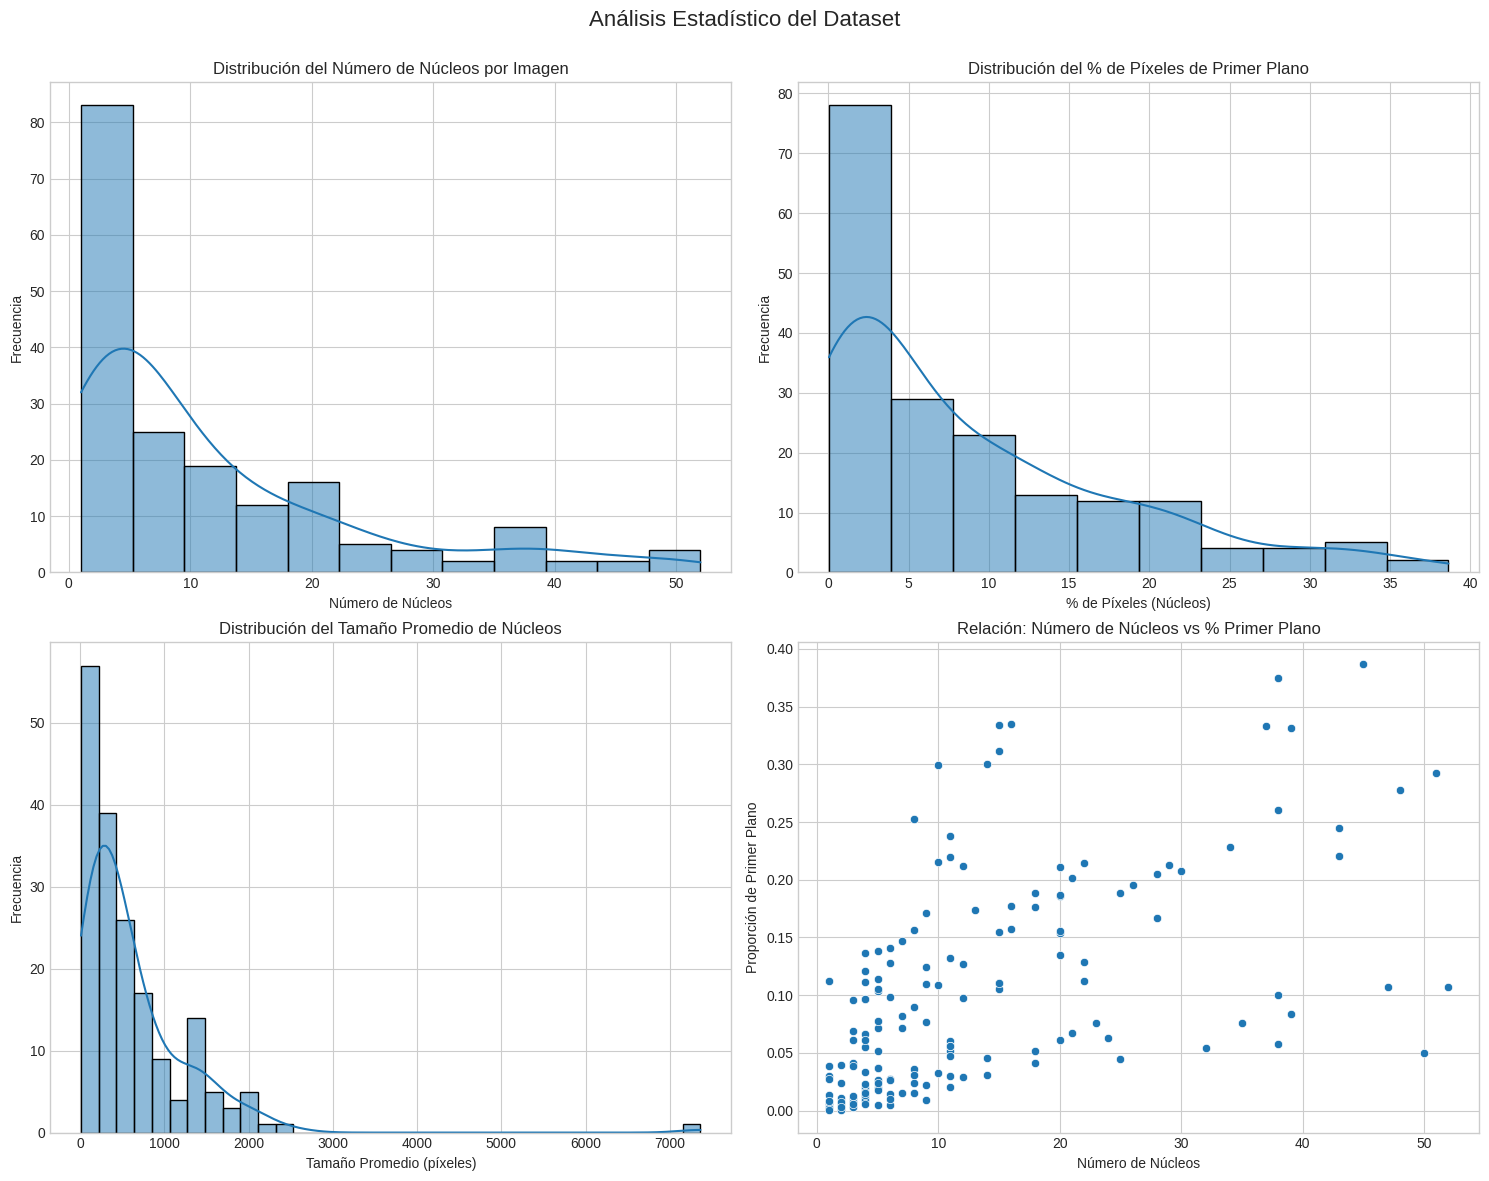

In [11]:
# Configurar figura para múltiples gráficos
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribución del número de núcleos por imagen
sns.histplot(df_stats['num_nuclei'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribución del Número de Núcleos por Imagen')
axes[0, 0].set_xlabel('Número de Núcleos')
axes[0, 0].set_ylabel('Frecuencia')

# Distribución del porcentaje de píxeles de primer plano
sns.histplot(df_stats['foreground_ratio']*100, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribución del % de Píxeles de Primer Plano')
axes[0, 1].set_xlabel('% de Píxeles (Núcleos)')
axes[0, 1].set_ylabel('Frecuencia')

# Distribución del tamaño promedio de núcleos
sns.histplot(df_stats['avg_nucleus_size'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribución del Tamaño Promedio de Núcleos')
axes[1, 0].set_xlabel('Tamaño Promedio (píxeles)')
axes[1, 0].set_ylabel('Frecuencia')

# Relación entre número de núcleos y proporción de primer plano
sns.scatterplot(x='num_nuclei', y='foreground_ratio', data=df_stats, ax=axes[1, 1])
axes[1, 1].set_title('Relación: Número de Núcleos vs % Primer Plano')
axes[1, 1].set_xlabel('Número de Núcleos')
axes[1, 1].set_ylabel('Proporción de Primer Plano')

plt.tight_layout()
plt.suptitle('Análisis Estadístico del Dataset', fontsize=16, y=0.98)
plt.subplots_adjust(top=0.92)
plt.show()

## 5. Identificación de Casos Desafiantes

In [12]:
# Encontrar casos extremos en el dataset
edge_cases = find_edge_cases(num_samples=200, return_top=3)

Analizando 200 muestras para encontrar casos extremos...


100%|██████████| 200/200 [00:00<00:00, 363.62it/s]


### 5.1 Imágenes con Mayor Número de Núcleos

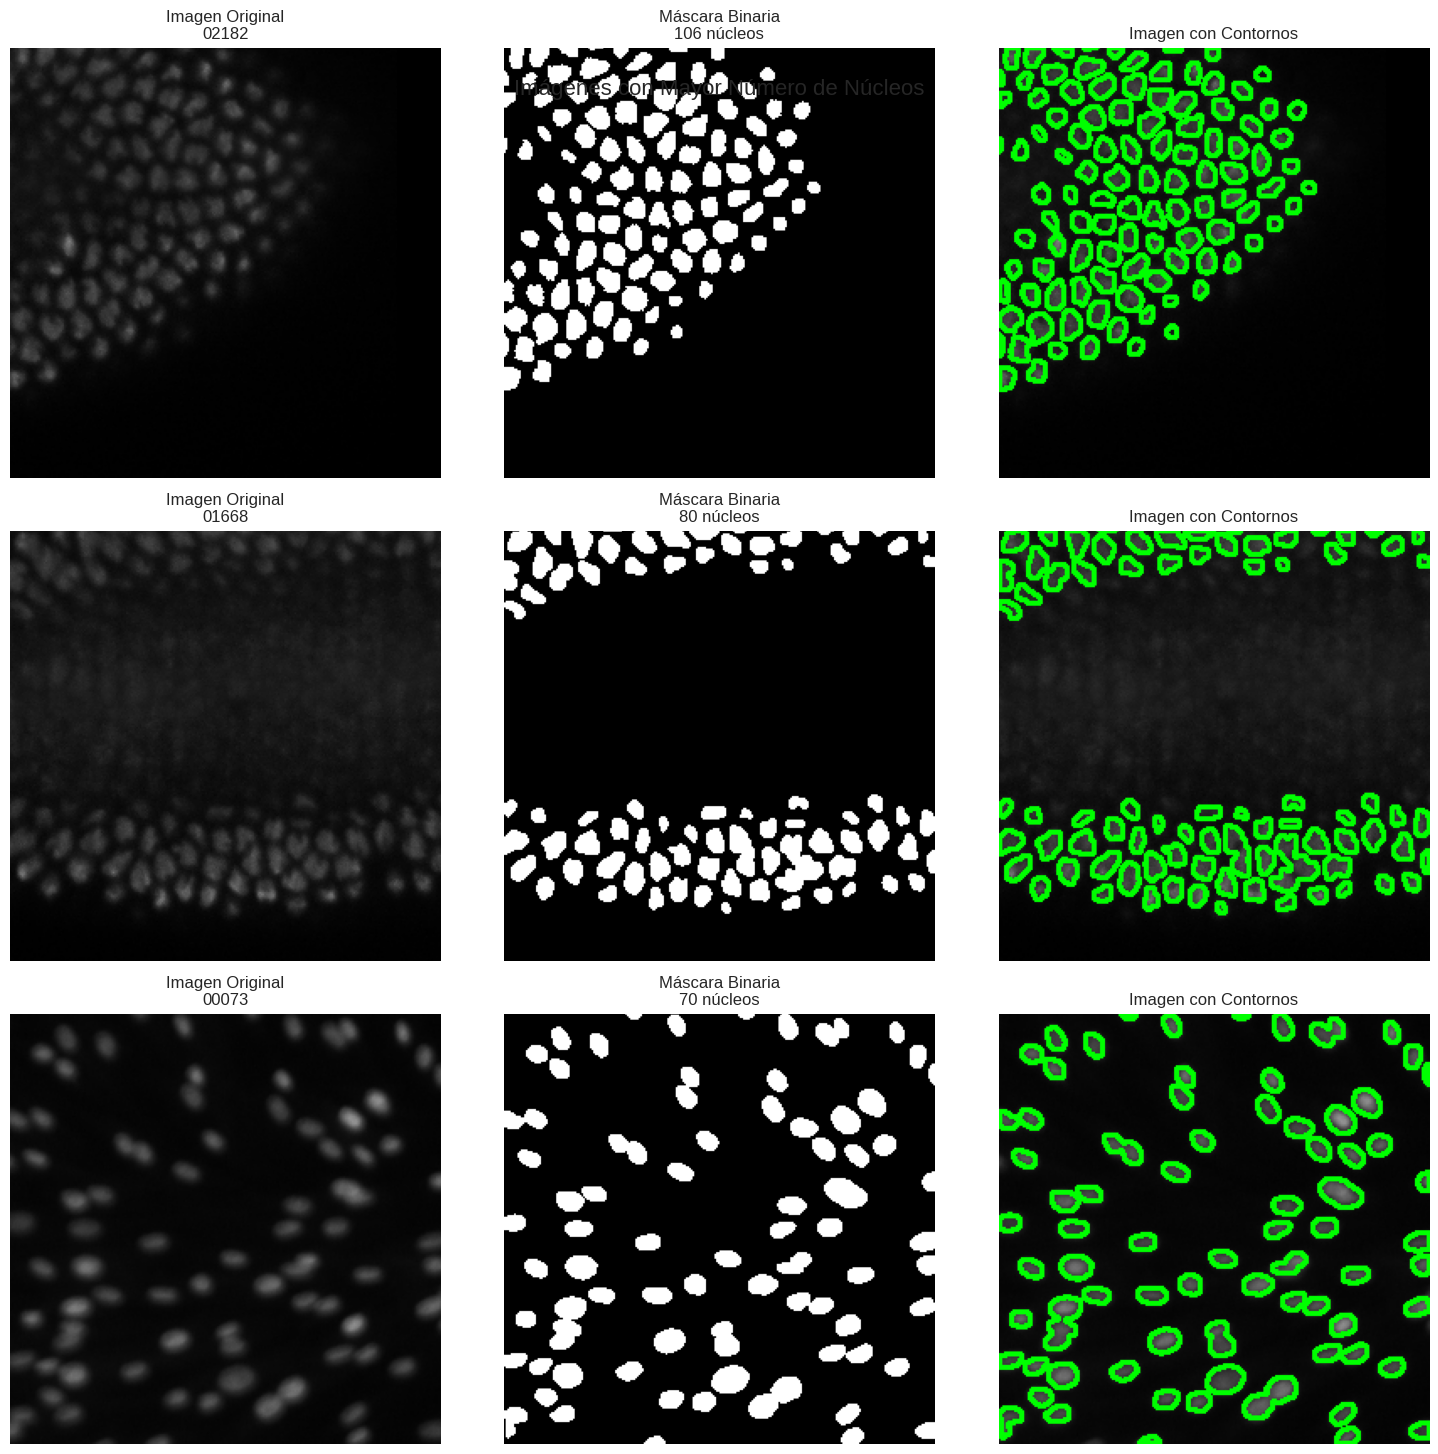

In [13]:
visualize_samples([dir_path for dir_path, _ in edge_cases['most_nuclei']],
                 "Imágenes con Mayor Número de Núcleos")

### 5.2 Imágenes con Núcleos Muy Pequeños

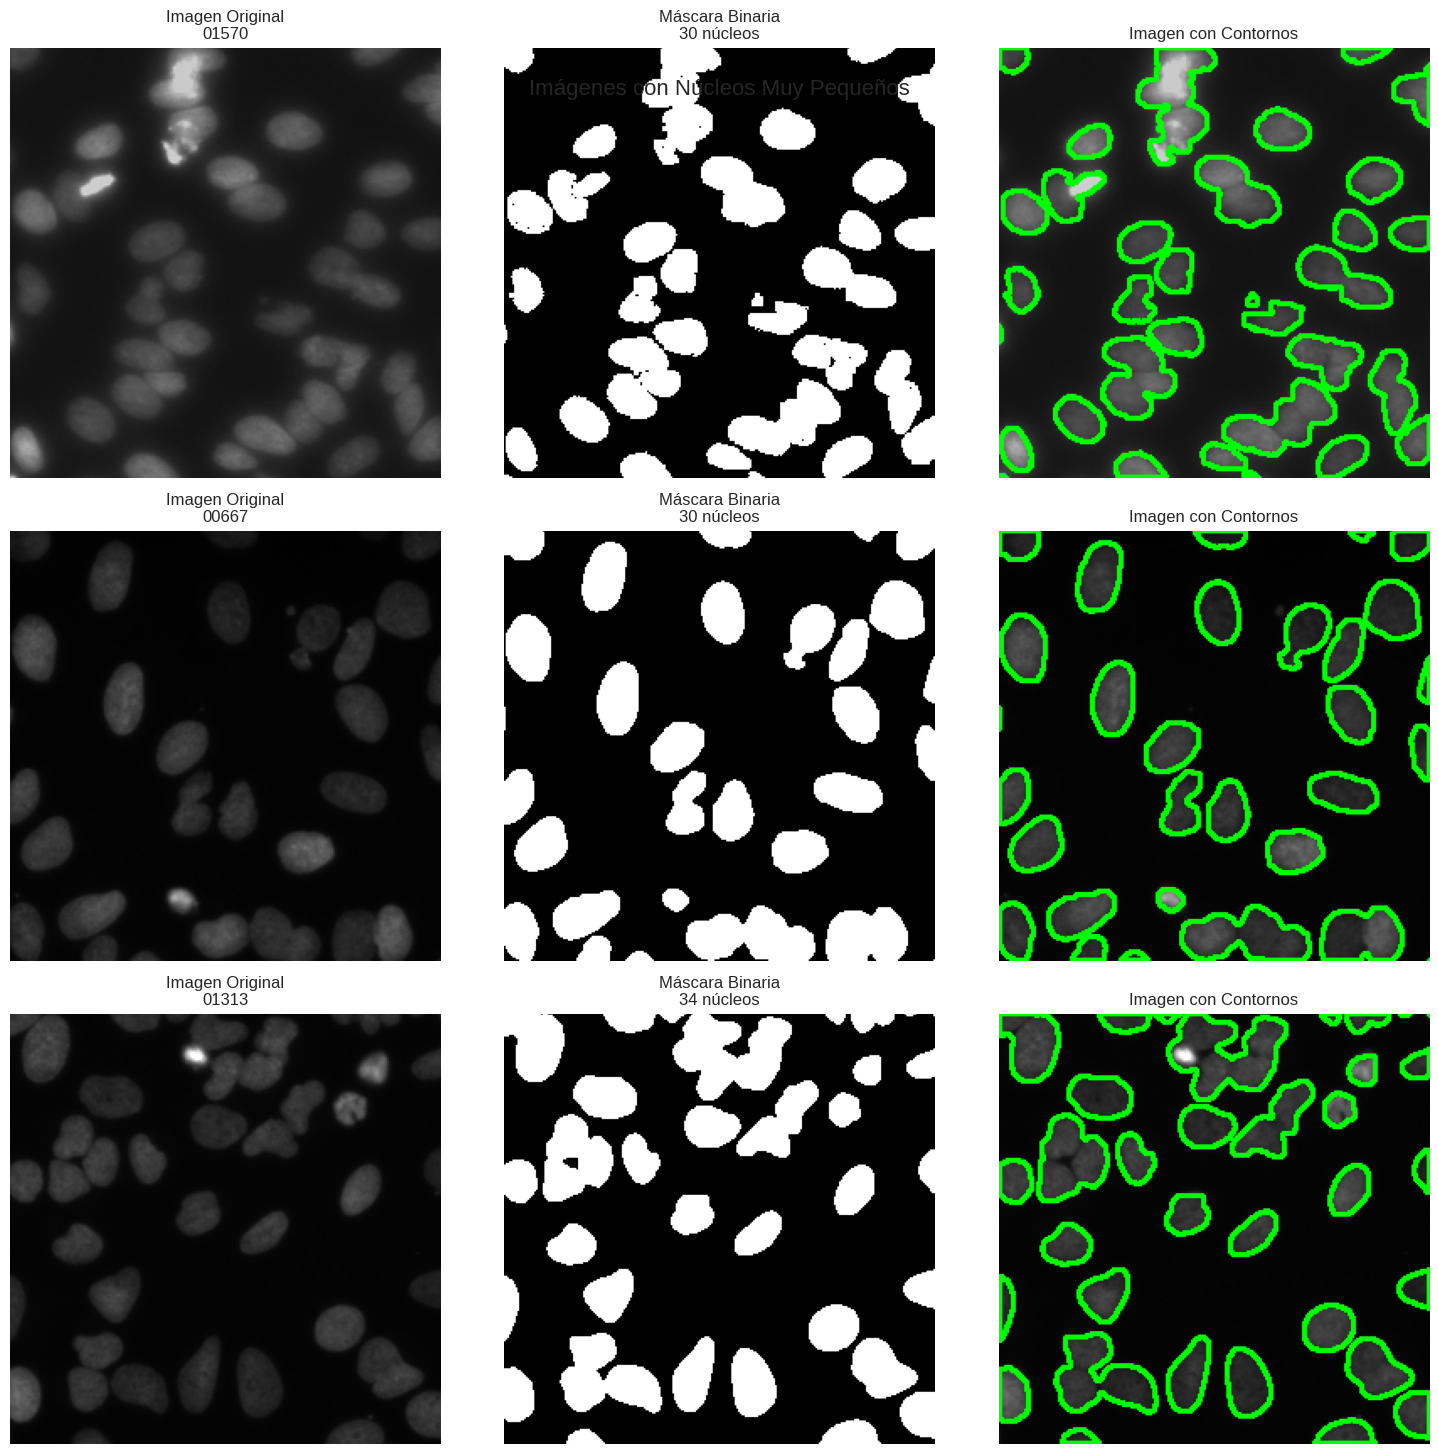

In [14]:
visualize_samples([dir_path for dir_path, _ in edge_cases['small_nuclei']],
                 "Imágenes con Núcleos Muy Pequeños")

### 5.3 Imágenes con Núcleos que Probablemente se Tocan

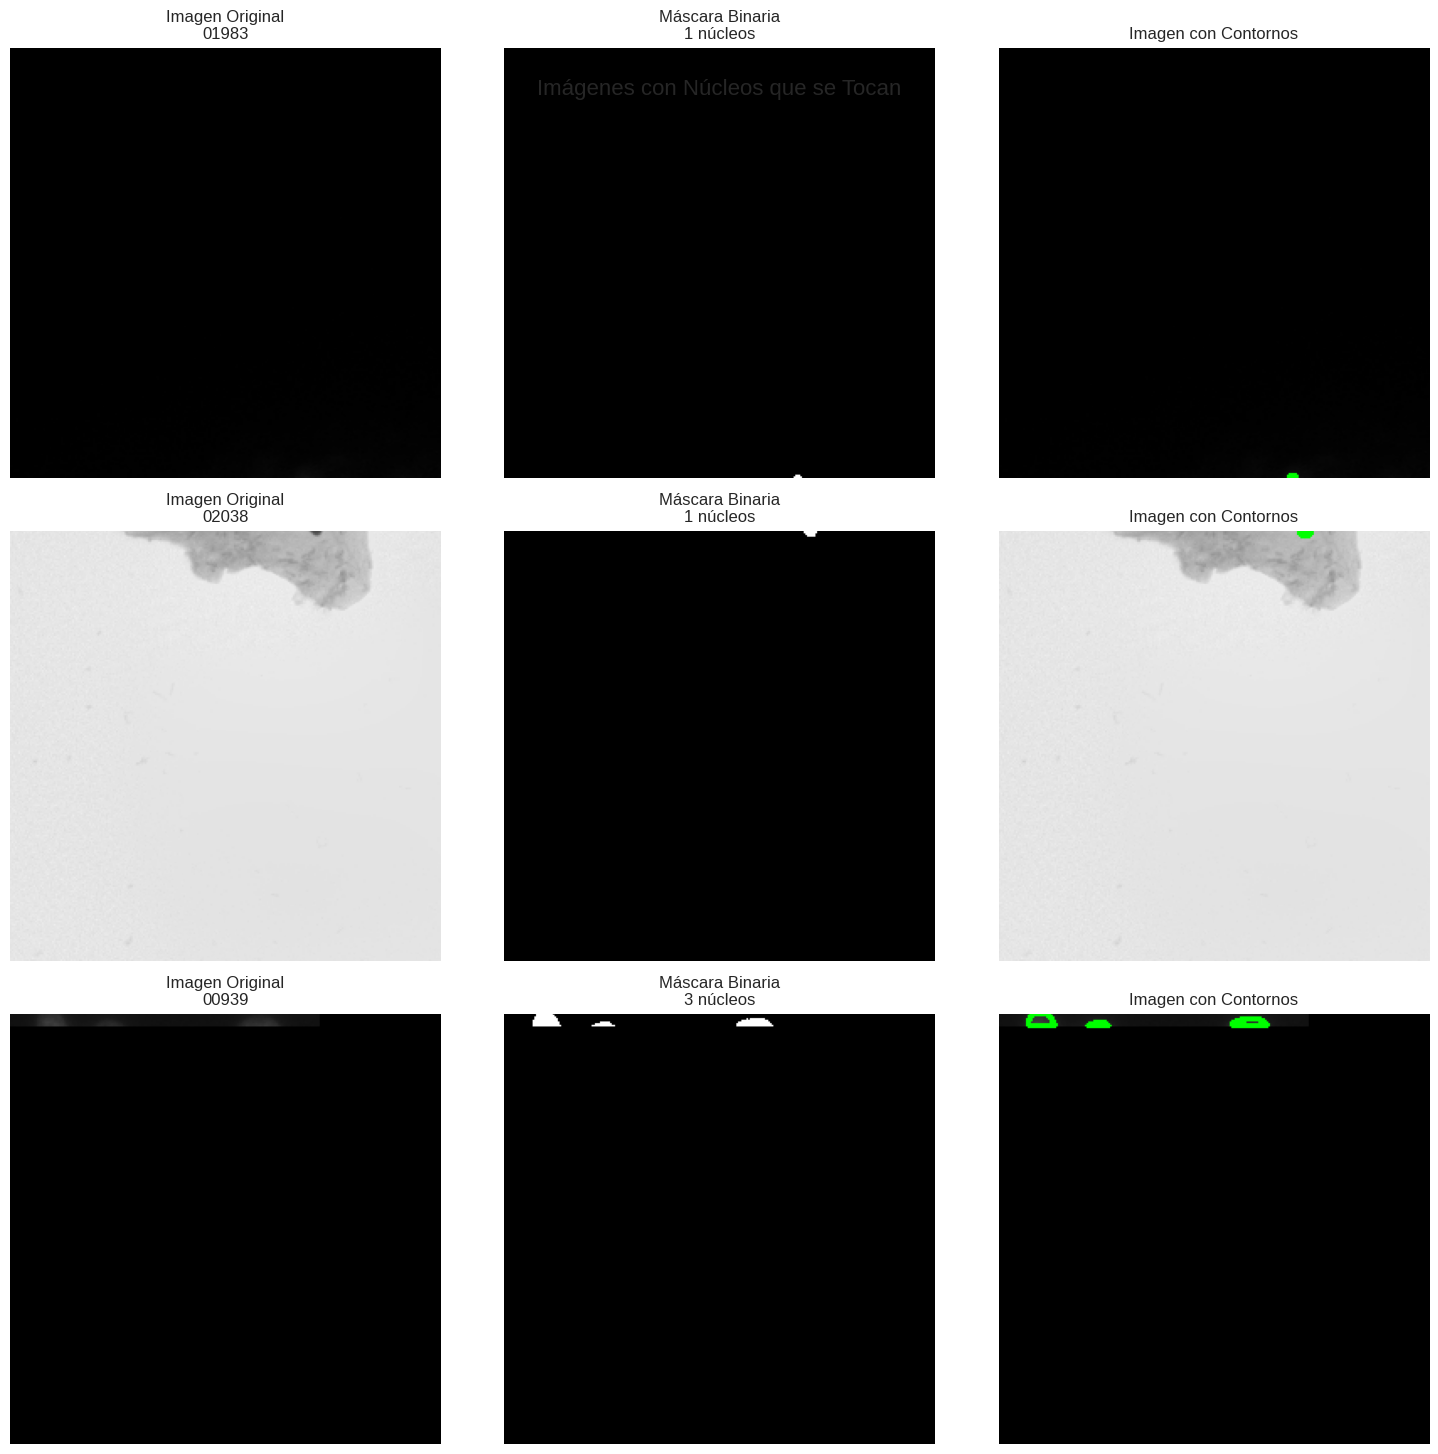

In [15]:
visualize_samples([dir_path for dir_path, _ in edge_cases['touching_nuclei']],
                 "Imágenes con Núcleos que se Tocan")

### 5.4 Imágenes con Alta Variabilidad de Iluminación

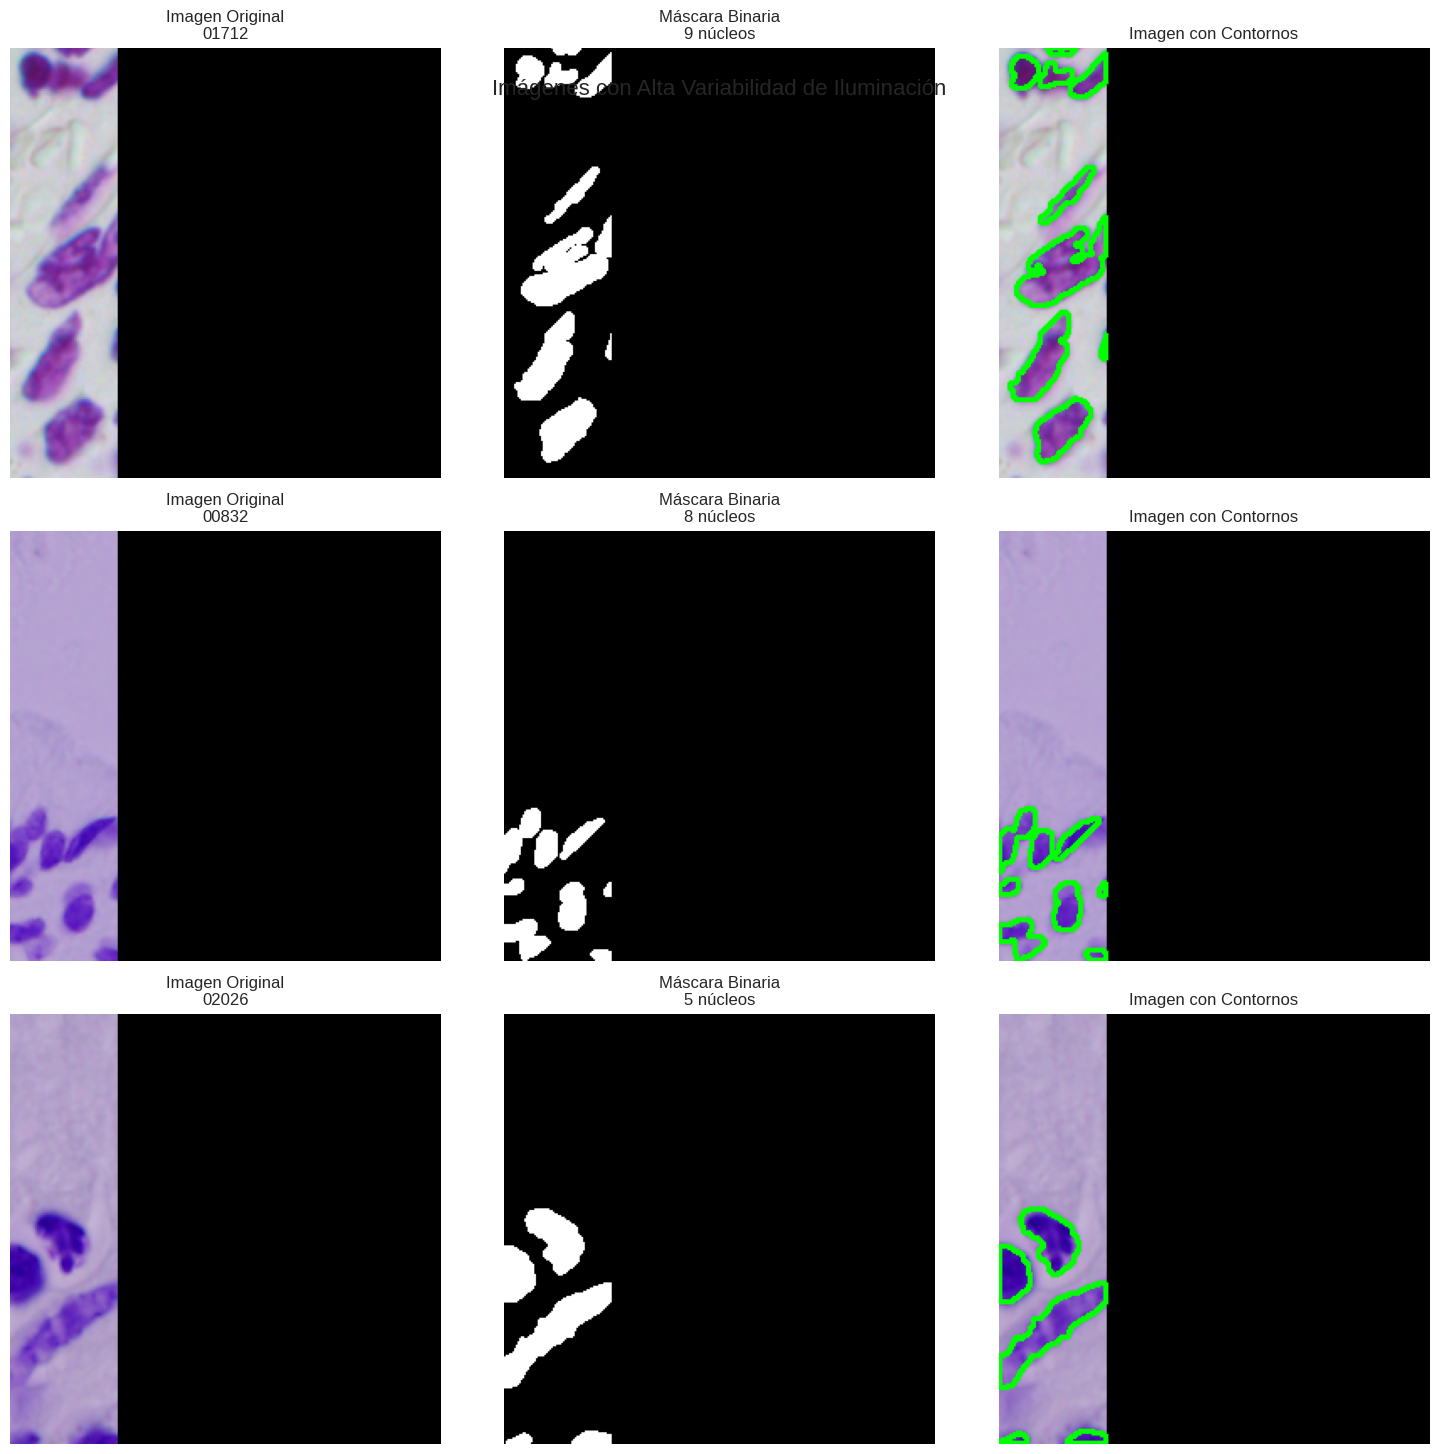

In [16]:
visualize_samples([dir_path for dir_path, _ in edge_cases['varied_brightness']],
                 "Imágenes con Alta Variabilidad de Iluminación")

## 6. Análisis de los Desafíos para el Modelo

In [25]:
def analyze_class_imbalance():
    """
    Analiza el desbalance de clases en el dataset y muestra su impacto
    """
    # Tomar muestras para análisis
    sample_dirs = get_random_samples(30, seed=42)
    
    # Recopilar datos de proporciones de clases
    fg_ratios = []
    bg_ratios = []
    
    for sample_dir in tqdm(sample_dirs):
        sample = load_sample(sample_dir)
        if sample is None:
            continue
            
        fg_ratio = sample['mask_foreground_ratio']
        bg_ratio = 1 - fg_ratio
        
        fg_ratios.append(fg_ratio)
        bg_ratios.append(bg_ratio)
    
    # Promedio de proporciones
    avg_fg = np.mean(fg_ratios)
    avg_bg = np.mean(bg_ratios)
    
    # Visualizar el desbalance
    plt.figure(figsize=(10, 6))
    plt.bar(['Fondo', 'Núcleos'], [avg_bg, avg_fg], color=['skyblue', 'coral'])
    plt.title('Proporción Promedio de Píxeles por Clase')
    plt.ylabel('Proporción')
    plt.grid(axis='y', alpha=0.3)
    
    # Añadir etiquetas de porcentaje
    for i, value in enumerate([avg_bg, avg_fg]):
        plt.text(i, value/2, f'{value*100:.1f}%', 
                 ha='center', va='center', fontsize=12, fontweight='bold', color='black')
    
    plt.show()
    

100%|██████████| 30/30 [00:00<00:00, 535.26it/s]


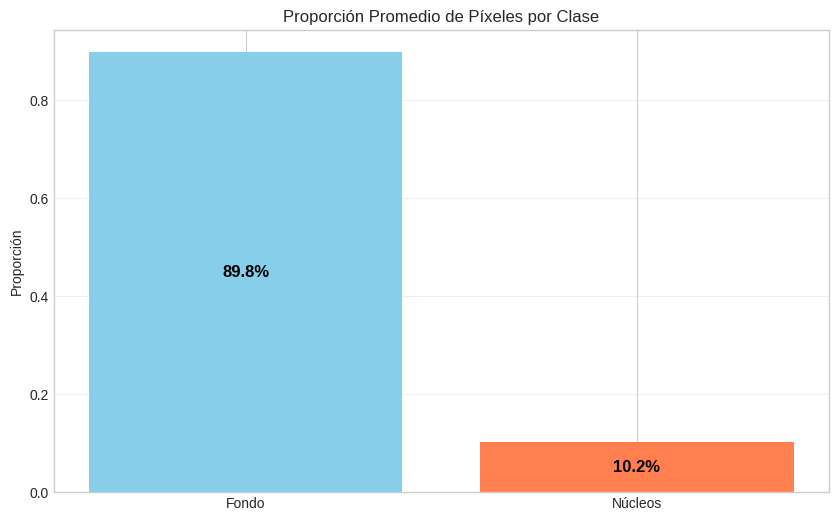

Proporción promedio de píxeles de núcleos: 10.20%
Proporción promedio de píxeles de fondo: 89.80%
Relación fondo:núcleos = 8.8:1

Implicaciones:
- Alta probabilidad de que el modelo prediga todo como fondo
- Necesidad de funciones de pérdida que manejen el desbalance
- Potencial utilidad de mapas de peso para dar importancia a los núcleos


In [18]:
analyze_class_imbalance()

## 7. Análisis de Bordes entre Núcleos que se Tocan

In [24]:
def analyze_touching_nuclei():
    """
    Analiza y visualiza el desafío específico de núcleos que se tocan
    """
    # Buscar muestra con núcleos que se tocan
    edge_cases = find_edge_cases(num_samples=100, return_top=1)
    sample_dir = edge_cases['touching_nuclei'][0][0]
    
    sample = load_sample(sample_dir)
    if sample is None:
        print("No se pudo cargar la muestra")
        return
    
    # Procesar máscara para identificar núcleos individuales
    mask = sample['mask']
    
    # Encontrar componentes conectados
    num_labels, labels = cv2.connectedComponents(mask)
    
    # Crear máscara dilatada para ver superposiciones
    kernel = np.ones((5,5), np.uint8)
    mask_dilated = cv2.dilate(mask, kernel, iterations=1)
    
    # Áreas de posible contacto
    touching_areas = mask_dilated & ~mask
    
    # Visualizar
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Imagen original
    axes[0, 0].imshow(sample['image'])
    axes[0, 0].set_title('Imagen Original')
    axes[0, 0].axis('off')
    
    # Máscara binaria
    axes[0, 1].imshow(mask, cmap='gray')
    axes[0, 1].set_title(f'Máscara Binaria ({num_labels-1} núcleos)')
    axes[0, 1].axis('off')
    
    # Núcleos etiquetados con colores diferentes
    cmap = plt.cm.tab10(np.linspace(0, 1, num_labels))
    colored_labels = np.zeros((*labels.shape, 3))
    
    for i in range(1, num_labels):
        colored_labels[labels == i] = cmap[i][:3]
    
    axes[1, 0].imshow(colored_labels)
    axes[1, 0].set_title('Núcleos Individuales')
    axes[1, 0].axis('off')
    
    # Áreas de contacto potenciales
    overlay = sample['image'].copy()
    overlay[touching_areas > 0] = [255, 0, 0]  # Marcar en rojo
    
    axes[1, 1].imshow(overlay)
    axes[1, 1].set_title('Áreas de Posible Contacto (Rojo)')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Análisis de Núcleos que se Tocan', fontsize=16, y=0.98)
    plt.subplots_adjust(top=0.92)
    plt.show()
    

Analizando 100 muestras para encontrar casos extremos...


100%|██████████| 100/100 [00:00<00:00, 394.63it/s]


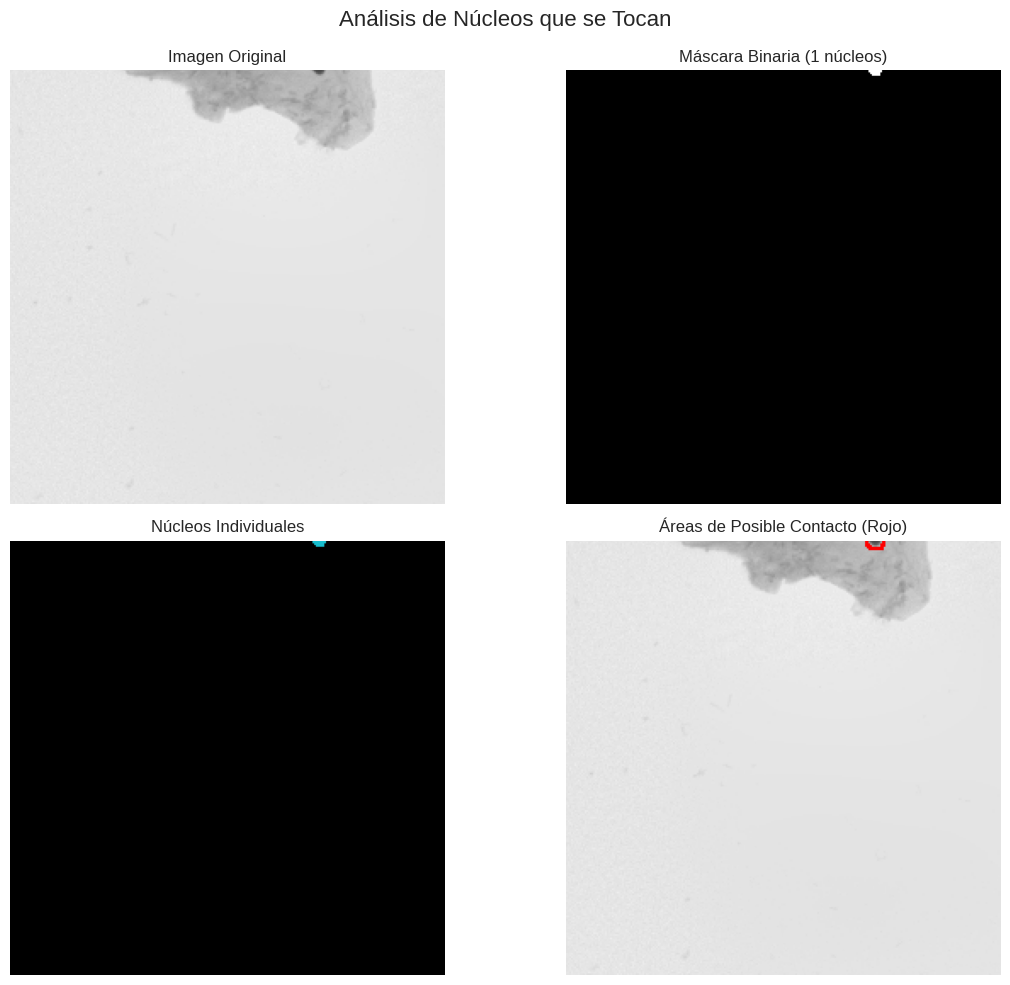

In [23]:
analyze_touching_nuclei()